In [138]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
def aggregate_individual_data_per_day(raw=pd.DataFrame, to_average=None ):
    """
    for the raw data of one individual a new df is generated with the variables as columns. Values are summed unless their variable name is 
    specified to be averaged in to_average.

    Parameters
    ----------
    INPUT
    raw : df
        DataFrame with the raw data
    to_average : array-like
        array specifiying which variables to average

    RETURNS
    processed : df
        DataFrame wiht the processed data
    """

    # add column with date only
    raw['time'] = pd.to_datetime(raw.loc[:,'time'])
    raw['date'] = raw['time'].dt.date

    # initialize new df with variables as columns
    vars = ['date', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']
    #    , 'mood_std', 'circumplex.arousal_std', 'circumplex.valence_std',
    #    'activity_std']
    processed = pd.DataFrame(columns= vars)

    # fill df
    # loop over days
    for i, day in enumerate(raw['date'].unique()):
        processed.loc[i, 'date'] = day
        row = (raw['date'] == day)

        # loop over variables
        for col in vars[1:-1]:

            # average values of given specified variables
            if col in to_average:
                processed.loc[i, col] = raw.loc[row & (raw['variable'] == col)].value.mean()
                #processed.loc[i, col+'_std'] = raw.loc[row & (raw['variable'] == col)].value.std()

            
            # sum values for the other variables
            else:
                processed.loc[i, col] = raw.loc[row & (raw['variable'] == col)].value.abs().sum()

    # sort the df according to date
    processed['date'] = pd.to_datetime(processed.loc[:,'date'])
    processed.sort_values('date')

    # drop rows without mood or or screen reading
    processed.drop(processed.loc[processed['mood'].isna() | (processed['screen'] == 0)].index, inplace=True)

    processed.reindex()

    processed.insert(1, 'weekday', processed['date'].dt.weekday)

    processed = processed.fillna(0)

    return processed

In [3]:
raw_data = pd.read_csv('data/dataset_mood_smartphone.csv')

In [4]:
unique_ids = raw_data['id'].unique()

In [77]:

# specify variables to average
to_average = np.array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])

# process df for each individual
processed_dfs = []
for i in tqdm(unique_ids):
    raw_df = raw_data.loc[raw_data['id'] == i].copy()
    processed_df = aggregate_individual_data_per_day(raw_df, to_average)
    processed_dfs.append(processed_df)
    #processed_df.to_csv('aggregated_individual_data/'+str(i)+'_aggregated.csv')

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


In [26]:
example = processed_dfs[1].copy()
example.head()

,date,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
0,2014-03-16,6,6.333333,0.0,0.00,0.000000,4902.627000,4.0,1.0,2526.424,...,88.392,0.0,0.0,0.0,408.106,181.591,0.000,0.0,0.0,0
1,2014-03-17,0,6.750000,0.5,0.50,0.168068,10159.769001,4.0,0.0,1229.347,...,2511.178,0.0,0.0,0.0,103.699,103.028,0.000,0.0,0.0,0
2,2014-03-18,1,8.200000,0.6,0.80,0.219484,4512.471001,15.0,1.0,2604.521,...,88.943,0.0,0.0,0.0,88.722,212.364,0.000,0.0,0.0,0
3,2014-03-19,2,6.800000,0.4,0.40,0.315632,8182.757000,5.0,1.0,1554.558,...,196.139,0.0,0.0,0.0,105.536,47.815,567.165,0.0,0.0,0
4,2014-03-20,3,7.250000,-0.5,0.75,0.239025,4360.334001,10.0,1.0,1777.977,...,148.180,0.0,0.0,0.0,86.857,131.598,0.000,0.0,0.0,0


In [29]:
vars = example.columns
# min max normalization
for i, col in enumerate(example.columns[2:len(vars)]):
    example[col] = (example[col]-example[col].min())/(example[col].max() - example[col].min())
    example[col] = example[col].fillna(0)


In [30]:
example.columns[2:len(vars)]

Index(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype='object')

In [31]:
example.head()
len(example.columns)

21

In [394]:
vars = ['date', 'weekday', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'mood_2days', 'mood_yesterday', '1day_mood_change', 'mood_target', 'target_bw' ]

forest_data = pd.DataFrame(columns = vars)

n_days = 7

for i, df_org in enumerate(processed_dfs):
    df = df_org.copy()

    for j, col in enumerate(example.columns[2:len(vars)]):
        df[col] = (df[col]-df[col].min())/(df[col].max() - df[col].min())
        df[col] = df[col].fillna(0)
        
    for j in range(len(df)-n_days-1):
        means = pd.DataFrame(df.iloc[j:j+n_days, 2:len(example.columns)].mean())
        forest_data = pd.concat([forest_data, means.transpose()], ignore_index=True)
        forest_data.iloc[-1, 0] = df['date'].iloc[j+n_days+1]
        forest_data.iloc[-1, 1] = df['weekday'].iloc[j+n_days+1]
        forest_data.iloc[-1, -5] = df['mood'].iloc[j+n_days-1]
        forest_data.iloc[-1, -4] = df['mood'].iloc[j+n_days]
        forest_data.iloc[-1, -2] = df['mood'].iloc[j+n_days+1]



for col in forest_data.columns:
    if (sum(forest_data[col] == 0)/len(forest_data[col])) > 0.3:
        forest_data = forest_data.drop(col, axis = 1)

forest_data['target_bw'] = forest_data['mood_target'] - forest_data['mood_yesterday']
forest_data['1day_mood_change'] = forest_data['mood_yesterday'] - forest_data['mood_2days']

<Axes: >

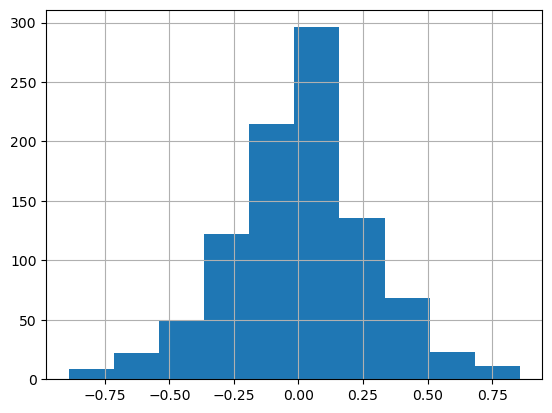

In [397]:
forest_data['1day_mood_change'].hist()

In [396]:
# labels = ['vl', 'l', 'm', 'h', 'vh']
# # build classes
# for i, col in enumerate(forest_data.columns[2:len(vars)]):
#     forest_data[col+'class'] = pd.cut(forest_data[col], 5, labels=labels)

In [398]:
len(forest_data.columns)

21

In [399]:
# delete constant columns
forest_data = forest_data.loc[:, (forest_data != forest_data.iloc[0]).any()] 
len(forest_data.columns)

21

In [382]:
from sklearn.ensemble import RandomForestClassifier

In [449]:
X = forest_data.iloc[:,1:-2].to_numpy()

#labels = ['vl', 'l', 'ml', 'm', 'mh', 'h', 'vh']
labels = ['vl', 'l', 'm', 'h', 'vh']
#labels = ['l', 'm', 'h']
#labels = ['three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
y = pd.cut(forest_data['mood_target'], 5, labels=labels)
y = y.to_numpy()

(array([142.,   0., 280.,   0.,   0.,  79.,   0., 179.,   0., 272.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

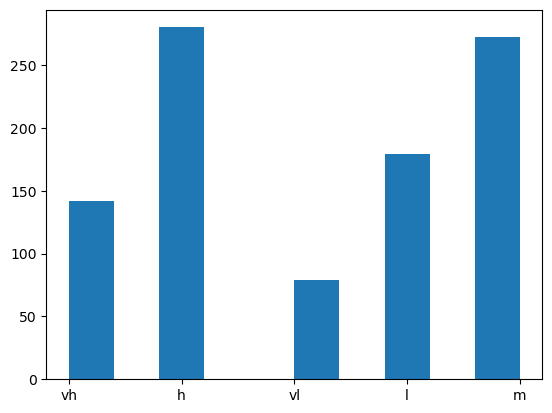

In [450]:
plt.hist(y)

In [451]:
forest_data.iloc[:,1:-2].head()

,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,appCat.utilities,mood_2days,mood_yesterday,1day_mood_change
0,5,0.267857,0.770035,0.485714,0.547224,0.620661,0.300000,0.107143,0.070543,0.483016,0.076362,0.082458,0.465320,0.125626,0.197111,0.5,0.2,-0.3
1,6,0.282143,0.714286,0.542857,0.522640,0.527783,0.285714,0.107143,0.137116,0.426025,0.076314,0.080535,0.351442,0.144875,0.154075,0.2,1.0,0.8
2,0,0.396429,0.686411,0.614286,0.414514,0.543295,0.300000,0.107143,0.148859,0.402423,0.111677,0.090491,0.352390,0.146214,0.224056,1.0,0.75,-0.25
3,1,0.446429,0.637631,0.607143,0.354484,0.527284,0.300000,0.107143,0.140475,0.360961,0.144902,0.090655,0.331495,0.146214,0.225246,0.75,0.7,-0.05
4,2,0.546429,0.581882,0.692857,0.349063,0.504444,0.242857,0.107143,0.160615,0.319508,0.162927,0.118803,0.278116,0.125296,0.229820,0.7,0.0,-0.7


In [452]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Hyperparameter tuning
param_dist = {'n_estimators': randint(10,100),
              'max_depth': randint(1,10)}

# Create a random forest classifier
rf = RandomForestClassifier(n_jobs = -1)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

In [ ]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

In [453]:
rf = RandomForestClassifier(max_depth = 10, n_estimators = 50, n_jobs = -1)

In [454]:
rf = rf.fit(X_train, y_train)

In [455]:
y_pred = rf.predict(X_test)

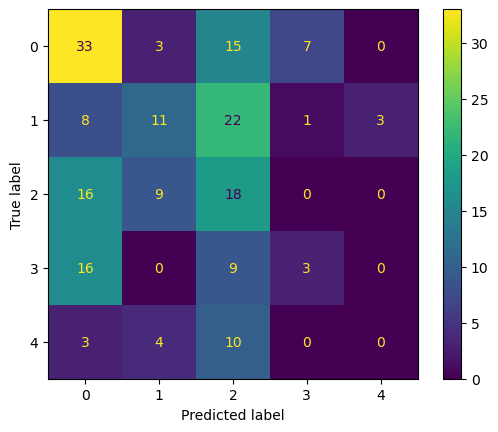

In [456]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [457]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           h       0.43      0.57      0.49        58
           l       0.41      0.24      0.31        45
           m       0.24      0.42      0.31        43
          vh       0.27      0.11      0.15        28
          vl       0.00      0.00      0.00        17

    accuracy                           0.34       191
   macro avg       0.27      0.27      0.25       191
weighted avg       0.32      0.34      0.31       191

